In [2]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil
import math
from matplotlib.colors import LinearSegmentedColormap

/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# DATA FOR EBM + NEXIS + DEEP LEARNING

prob_stage = pandas.DataFrame(pk['prob_stage'])
ml_stage = pandas.DataFrame(pk['ml_stage'])

cn_indices = zdata[zdata['Diagnosis'] == 'CN'].index
prob_stage = prob_stage.drop(cn_indices)
zdata = zdata.drop(cn_indices)
prob_stage.reset_index(drop=True, inplace=True)
zdata.reset_index(drop=True, inplace=True)
probability_distributions = pandas.merge(prob_stage, zdata, left_index=True, right_index=True)
probability_distributions = probability_distributions[['RID', 'ml_stage', 'Diagnosis',0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
probability_distributions.to_csv('Probability Distributions SuStaIn - test.csv')


In [65]:
# Calculate stage for longitudinal data assuming 1 year = 1 stage 

# Load data
zdata = pandas.read_csv('../zdata/zdata- version 9 final run.csv')
zdata = zdata.drop(['Unnamed: 0','Unnamed: 0_x'], axis=1)
exam_dates = pandas.read_csv('../data/ADNI3/ADNI_neg_zscores_orig.csv')
tau = pandas.read_csv('../data/ADNI3/Cog_Tau_V1.csv')

# Drop subjects with excluded RIDs
values_to_drop = [6601, 6509, 4513, 6038, 6505, 6598]
exam_dates = exam_dates[~exam_dates['merge_RID'].isin(values_to_drop)]
tau = tau[~tau['merge_RID'].isin(values_to_drop)]

# Convert merge_EXAMDATE to datetime
exam_dates['merge_EXAMDATE'] = pandas.to_datetime(exam_dates['merge_EXAMDATE'])

exam_dates = exam_dates.sort_values(['merge_RID', 'merge_EXAMDATE'])

# Initialize time_elapsed and ml_stage columns
exam_dates['time_elapsed'] = 0.0
exam_dates['ml_stage'] = np.nan

# Group by RID
for rid, group in exam_dates.groupby('merge_RID'):
    # Check if RID is longitudinal 
    if len(group) > 1:
        # Calculate time elapsed between baseline and follow-up visits
        baseline_date = group['merge_EXAMDATE'].iloc[0]
        group['time_elapsed'] = (group['merge_EXAMDATE'] - baseline_date).dt.days / 365.25
        
        # Get ml_stage from zdata 
        ml_stage = zdata[zdata['RID'] == rid]['ml_stage'].values
        if len(ml_stage) > 0:
            baseline_stage = ml_stage[0]
            
            # Set ml_stage for baseline
            group.iloc[0, group.columns.get_loc('ml_stage')] = baseline_stage
            
            # Calculate and set ml_stage for follow-up visits
            group.iloc[1:, group.columns.get_loc('ml_stage')] = baseline_stage + group.iloc[1:]['time_elapsed']
        
        exam_dates.loc[group.index] = group

# Round ml_stage to the nearest integer
exam_dates['ml_stage'] = exam_dates['ml_stage'].round(0)

#Housekeeping
columns_to_keep_exam = ['merge_RID', 'merge_EXAMDATE', 'merge_DX', 'time_elapsed', 'ml_stage']
exam_dates = exam_dates[columns_to_keep_exam]
exam_dates = exam_dates.rename(columns={
    'merge_RID': 'RID',
    'merge_EXAMDATE': 'EXAMDATE',
    'merge_DX': 'DX'})
columns_to_keep_tau = ['merge_RID', 'ctx-rh-bankssts'] + tau.columns[tau.columns.get_loc('ctx-rh-bankssts'):].tolist()
tau = tau[columns_to_keep_tau]
tau = tau.rename(columns={'merge_RID': 'RID'})

# Cerebellum normalization 
tau['Average_Cerebellum'] = (tau['Left-Cerebellum-Cortex']+ tau['Right-Cerebellum-Cortex'])/2
tau.iloc[:, 1:] = tau.iloc[:, 1:].div(tau['Average_Cerebellum'], axis=0) - 1
tau = tau.drop('Average_Cerebellum', axis=1)

,RID,ctx-rh-bankssts,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,21,0.188095,0.188095,0.037333,0.043333,0.101143,0.105429,0.172952,0.108952,0.262952,...,0.300381,-0.012667,0.381143,0.200476,0.429714,0.608857,0.511524,0.185333,0.321238,0.304762
1,31,0.100474,0.100474,0.094250,0.020352,0.085853,0.258645,0.143351,0.063525,0.105710,...,0.173088,0.009089,0.126161,0.065896,0.398439,0.592472,0.335902,0.280676,0.231871,0.215768
2,31,0.055581,0.055581,0.057278,-0.000350,0.072160,0.215581,0.130587,0.028814,0.053383,...,0.182122,0.006242,0.076355,-0.012834,0.341523,0.509913,0.323346,0.305868,0.177628,0.165943
3,56,0.239668,0.239668,0.098082,0.106387,0.161360,0.248072,0.223255,0.165019,0.215543,...,0.356140,0.007317,0.320842,0.238185,0.666008,0.781590,0.341507,0.216235,0.244018,0.339529
4,56,0.280558,0.280558,0.166421,0.138014,0.205315,0.241256,0.233518,0.214478,0.239526,...,0.434302,0.003920,0.388790,0.267424,0.678664,0.882503,0.404470,0.284427,0.270580,0.404164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,6704,0.233781,0.233781,0.092975,0.076744,0.104641,0.098656,0.172407,0.144814,0.188435,...,0.277606,0.007355,0.197261,0.148973,0.437991,0.583363,0.166624,0.161248,0.168146,0.283084
815,6705,0.144939,0.144939,-0.043662,-0.034568,-0.023614,0.061644,0.119000,0.039735,0.101121,...,0.162197,0.019790,0.186069,0.050483,0.495582,0.548597,0.138428,0.217796,0.168191,0.190823
816,6713,0.034915,0.034915,-0.109553,-0.093523,-0.048840,0.414316,0.180784,0.007263,0.222562,...,0.131593,0.003657,0.047638,-0.031608,0.293493,0.368832,0.304914,0.515403,0.153634,0.123378
817,6721,0.246493,0.246493,0.109761,0.045940,0.121419,0.214681,0.228413,0.176250,0.255187,...,0.357143,-0.013831,0.410591,0.209741,0.661035,0.912172,0.299546,0.309425,0.449516,0.384311


In [66]:
# Sort tau and exam_dates by RID
tau_sorted = tau.sort_values('RID')
exam_dates_sorted = exam_dates.sort_values('RID')

# Reset index to create a new column for matching
tau_sorted = tau_sorted.reset_index(drop=True)
exam_dates_sorted = exam_dates_sorted.reset_index(drop=True)

# Add a temporary column to both dataframes for matching
tau_sorted['temp_index'] = tau_sorted.groupby('RID').cumcount()
exam_dates_sorted['temp_index'] = exam_dates_sorted.groupby('RID').cumcount()

# Merge the dataframes based on RID and the temporary index
longitudinal_stage_tau = pandas.merge(tau_sorted, exam_dates_sorted, 
                                      on=['RID', 'temp_index'], 
                                      how='inner', 
                                      suffixes=('_tau', '_exam'))

# Drop the temporary index column
longitudinal_stage_tau = longitudinal_stage_tau.drop('temp_index', axis=1)

# Sort the final dataframe by RID and EXAMDATE from exam_dates
longitudinal_stage_tau = longitudinal_stage_tau.sort_values(['RID', 'EXAMDATE'])

longitudinal_stage_tau.to_csv('../stage and tau/longitudinal_stage_tau.csv')

Slope: 0.18739027440986739


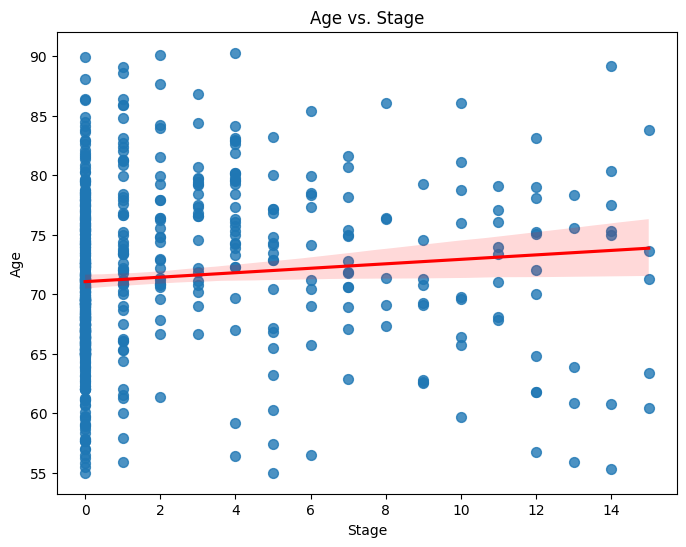

In [27]:
# Plot age vs. stage assignment 
zdata = pandas.read_csv('../zdata/zdata- version 9 final run.csv')
zdata = zdata.drop(['Unnamed: 0','Unnamed: 0_x'], axis=1)
age_data = pandas.read_csv('../data/ADNI3/age_data.csv')
value_to_drop = [6601, 6509]  
age_data = age_data[~age_data['RID'].isin(value_to_drop)]
age_stage = pandas.merge(zdata, age_data, on='RID', how='inner')

slope, intercept = np.polyfit(age_stage['ml_stage'], age_stage['AGE_x'], 1)
print(f"Slope: {slope}")

plt.figure(figsize=(8, 6))
sns.regplot(x='ml_stage', y='AGE_x', data=age_stage, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Stage')
plt.ylabel('Age')
plt.title('Age vs. Stage')
plt.show()


In [18]:
# Access pickle file
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [60]:
# Define which ml_stages to exclude from analysis #EDIT HERE
# stages_to_remove = []
# diagnoses_to_remove = ''

In [19]:
# Load specific zdata you want to analyze (make sure the number of subtypes and input features are correct)
zdata = pandas.read_csv('../zdata/zdata- version 9 final run.csv')

#Housekeeping
#zdata = zdata.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

# Delete subjects with stages or dignoses to exclude 
# zdata = zdata[~zdata['ml_stage'].isin(stages_to_remove)]
# zdata = zdata[zdata['Diagnosis'] != diagnoses_to_remove]
#reduced_RIDs = zdata.RID.tolist()
zdata

,Unnamed: 0,Unnamed: 0_x,RID,Diagnosis,AGE,ADAS11_bl,Average_hippo,Average_meta_tau,ctx_entorhinal_tau,ctx_inferiorparietal_tau,...,Average_inferiorparietal_vol,Average_inferiortemporal_vol,Unnamed: 0_y,RID_y,Tmax,R,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,0,0,21,CN,72.6,-0.172429,0.062109,0.134515,-0.011721,-0.175590,...,-0.239702,1.704690,0,21,0,0.237976,0.0,1.0,0.0,0.455396
1,1,1,31,CN,77.7,-1.735559,2.046008,-0.392692,0.623041,-0.477772,...,0.279301,1.286340,1,31,0,0.170120,0.0,1.0,0.0,0.385986
2,2,3,56,MCI,69.6,-1.319766,0.710701,0.456155,1.153732,0.418942,...,0.967623,1.773868,2,56,0,0.189343,0.0,1.0,0.0,0.403527
3,3,5,59,MCI,70.9,-0.069262,0.581602,0.544075,0.635106,0.399789,...,1.746611,1.869215,3,59,0,0.175158,0.0,1.0,2.0,0.215246
4,4,6,69,MCI,72.9,0.346530,0.370436,1.093217,0.857338,0.732524,...,0.361946,0.004851,4,69,1,0.188655,0.0,1.0,2.0,0.215477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,645,812,6704,MCI,65.3,3.160164,0.470892,-0.188450,-0.323373,0.191931,...,1.024877,1.925646,645,6702,0,0.158287,0.0,1.0,1.0,0.446163
646,646,813,6705,MCI,74.9,0.971782,2.098817,1.965910,2.678315,1.139518,...,0.080927,-0.253239,646,6703,0,0.186192,0.0,1.0,7.0,0.234792
647,647,814,6713,CN,71.1,0.971782,0.521152,-0.249232,-0.260623,0.234837,...,-0.754194,-0.464371,647,6704,0,0.167050,0.0,1.0,0.0,0.424969
648,648,815,6721,Dementia,77.9,3.785416,2.874163,-0.762779,-0.695716,-1.116853,...,-0.699300,-0.347036,648,6705,0,0.144258,0.0,1.0,2.0,0.357975


In [10]:
# SPECIFY THE NUMBER OF SUBTYPES
nsubtypes = 1

In [11]:
if nsubtypes > 1:
    print(zdata.ml_subtype.value_counts())
    
print(zdata.ml_stage.value_counts())
print(zdata.Diagnosis.value_counts())

ml_stage
0.0     407
1.0      57
4.0      31
2.0      29
3.0      22
5.0      19
7.0      14
6.0      11
12.0     11
10.0      9
9.0       9
11.0      8
14.0      7
8.0       6
15.0      5
13.0      5
Name: count, dtype: int64
Diagnosis
CN          390
MCI         196
Dementia     64
Name: count, dtype: int64


## Generate Stage Histogram

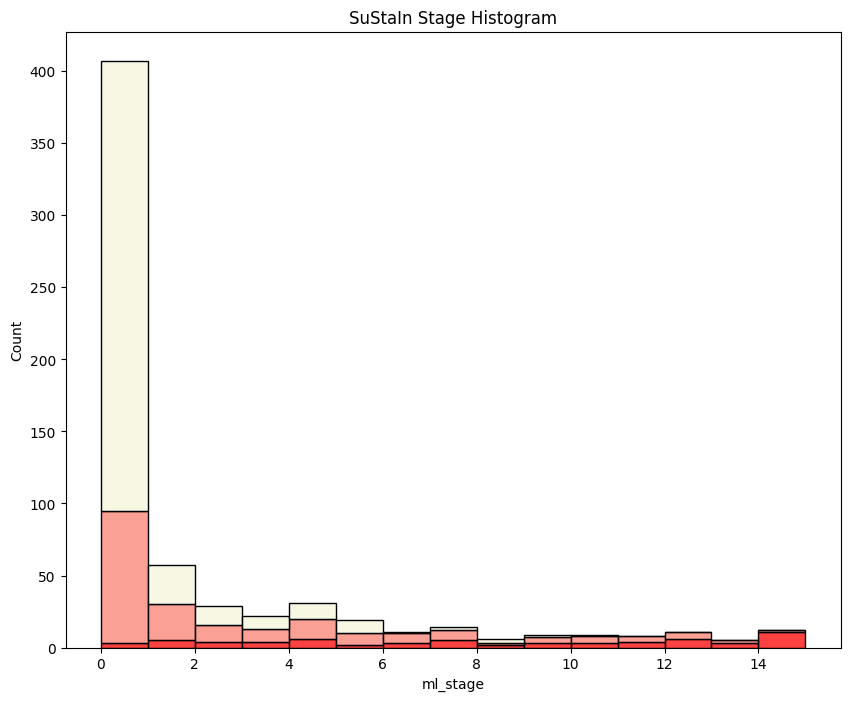

In [12]:
# Use clincial diagnostic categories as a rough way to assess the success of the model's stage assignments
color_palette = {
    'Dementia': '#FE0101',  # Deep red
    'MCI': '#FA8072',  # Salmon
    'CN': '#F5F5DC'}   # Beige (light beige)
    
if nsubtypes < 2: # If only one subtype
    plt.figure(figsize=(10, 8))
    ax = sns.histplot(data=zdata, x='ml_stage', hue='Diagnosis', bins=15, palette=color_palette, multiple='stack', legend=False)

    # Adjust the legend
    legend = ax.get_legend()
    if legend:
        legend.set_title('Diagnosis')
        plt.setp(legend.get_title(), fontsize='30')  # for legend title
        plt.setp(legend.get_texts(), fontsize='25')  # for legend text

    # Remove axis labels, tick numbers, and title
    # ax.set(xlabel=None, ylabel=None, title=None)  # Remove axis labels and title
    # ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
    # ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks
        
    plt.title('SuStaIn Stage Histogram')

    plt.show()
    
else:  # If multiple subtypes
    sns.displot(data=zdata, x='ml_stage', hue='Diagnosis', bins=15, palette=color_palette, col='ml_subtype', kind='hist', multiple='stack')
    plt.show()

<Figure size 1200x800 with 0 Axes>

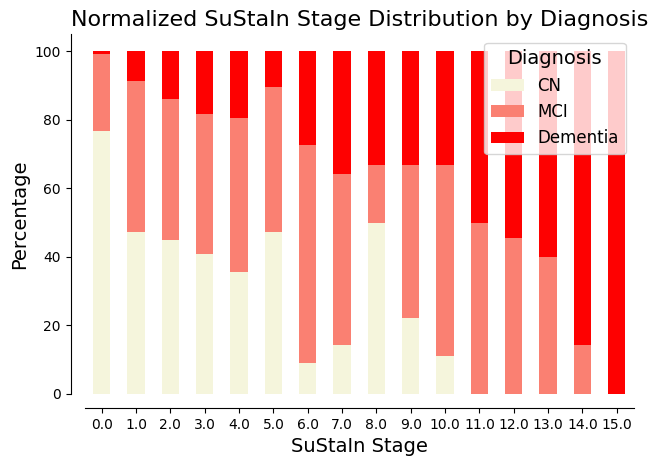

In [22]:
# Create a normalized stacked bar chart
plt.figure(figsize=(12, 8))

# Group the data by ml_stage and Diagnosis, then count the occurrences
stage_diagnosis_counts = zdata.groupby(['ml_stage', 'Diagnosis']).size().unstack(fill_value=0)

# Sort the index (ml_stage) to ensure proper ordering
stage_diagnosis_counts = stage_diagnosis_counts.sort_index()

# Calculate the percentage for each diagnosis within each stage
stage_diagnosis_percentages = stage_diagnosis_counts.apply(lambda x: x / x.sum() * 100, axis=1)

# Reorder the columns to have AD at the bottom, then MCI, then CN
stage_diagnosis_percentages = stage_diagnosis_percentages[['CN', 'MCI', 'Dementia']]

# Create the normalized stacked bar chart with the new order
ax = stage_diagnosis_percentages.plot(kind='bar', stacked=True, color=[color_palette[d] for d in stage_diagnosis_percentages.columns])

# Customize the plot
plt.title('Normalized SuStaIn Stage Distribution by Diagnosis', fontsize=16)
plt.xlabel('SuStaIn Stage', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Diagnosis', fontsize=12, title_fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Extend the left and bottom spines to the edges of the plot
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#plt.legend().remove()  
plt.show()

# Trajectory plots for each biomarker

In [408]:
# store our biomarker labels as a variable
biomarkers = zdata.columns[[5,6,8,12,13]]
print(biomarkers)

Index(['ADAS11_bl', 'Average_hippo', 'ctx_entorhinal_tau', 'Hippocampus_tau',
       'Amygdala_tau'],
      dtype='object')


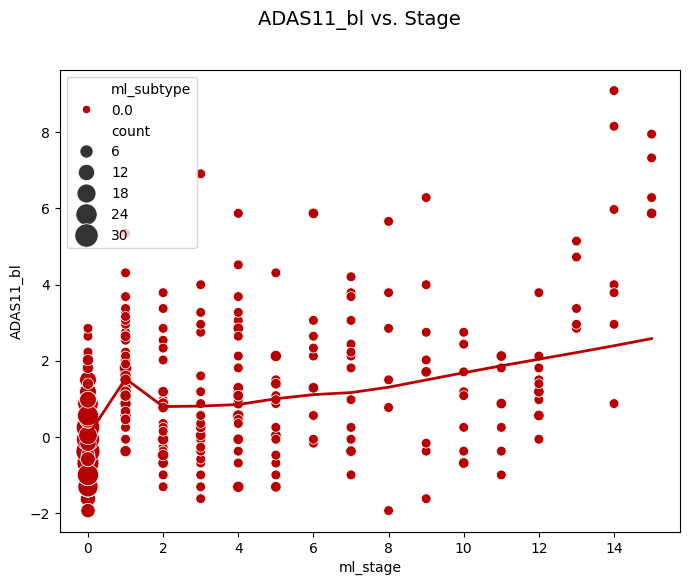

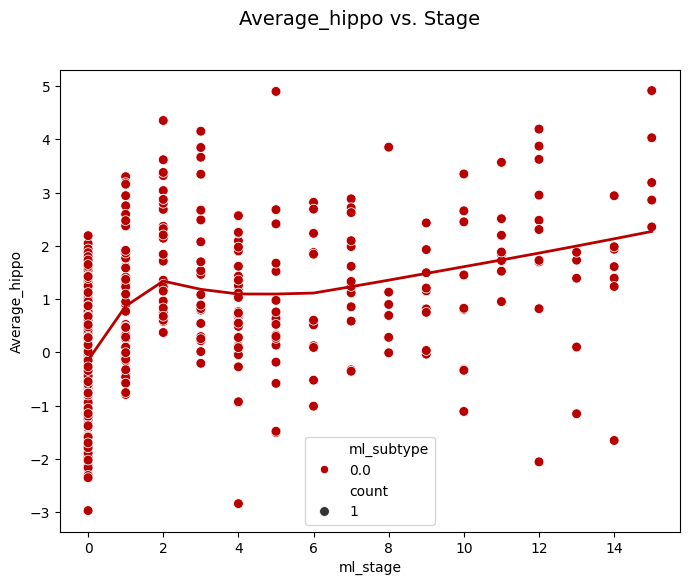

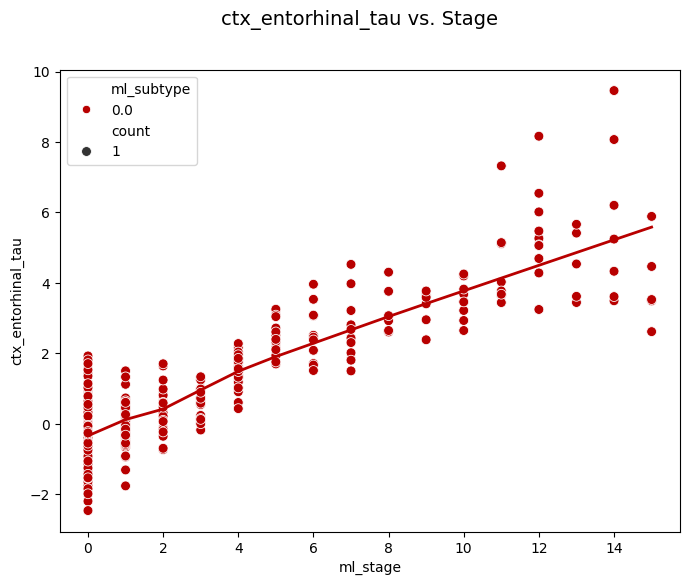

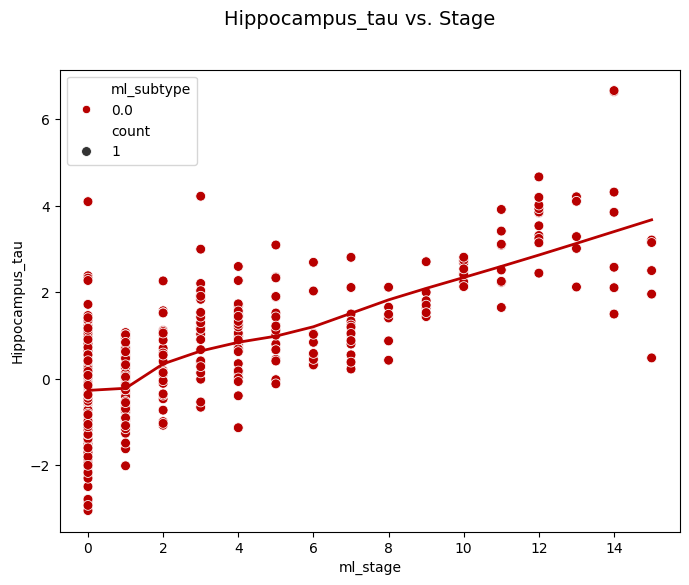

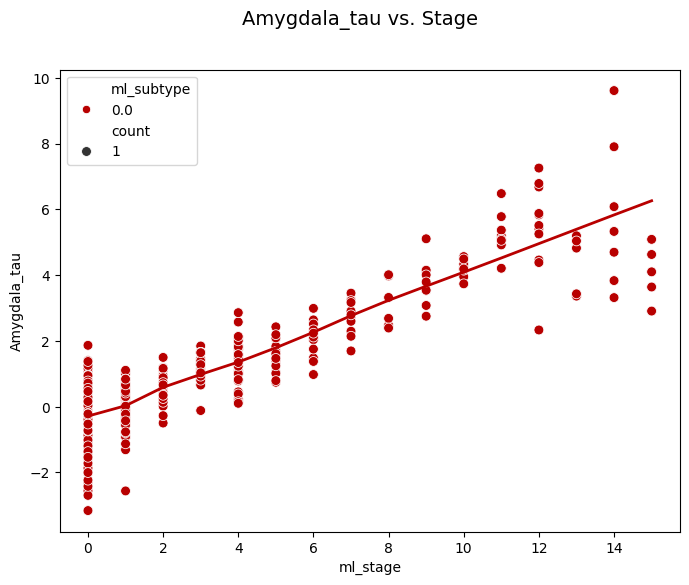

In [427]:
# Plot biomarker trajectories by subtype

color_palette_dark = {
    0.0: '#B80000',  # Darker deep red
    1.0: '#CD5C5C',      # Darker salmon (Indian Red)
    2.0: '#D2B48C'        # Darker beige (Tan)
}

for biomarker in biomarkers:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed

    # Count occurrences of each (x, y) pair
    count_series = zdata.groupby(['ml_stage', biomarker]).size().reset_index(name='count')
    zdata_with_count = pandas.merge(zdata, count_series, on=['ml_stage', biomarker], how='left')

    # Plot scatter points
    sns.scatterplot(x='ml_stage', y=biomarker, data=zdata_with_count, 
                    hue='ml_subtype', size='count', palette=color_palette_dark,
                    sizes=(50, 300), legend=True)

    # Add a regression line for each ml_subtype
    for subtype, color in color_palette_dark.items():
        subtype_data = zdata_with_count[zdata_with_count['ml_subtype'] == subtype]
        sns.regplot(x='ml_stage', y=biomarker, data=subtype_data, 
                    scatter=False, 
                    color=color, 
                    lowess=True,
                    line_kws={'lw': 2, 'alpha': 1.0, 'label': subtype})  # Thinner line (lw: line width)

    # Add a title to the plot
    plt.gcf().suptitle(f'{biomarker} vs. Stage', fontsize=14) 

    # Remove x and y axis labels if needed
    ax = plt.gca()

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())

    plt.show()

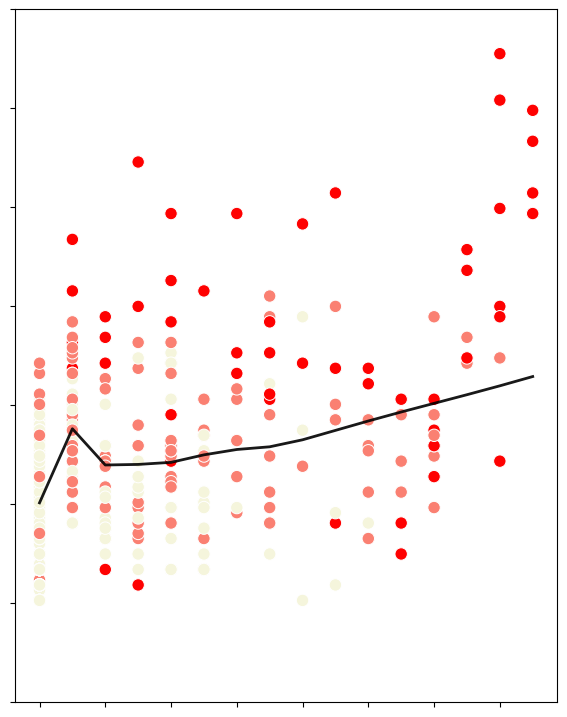

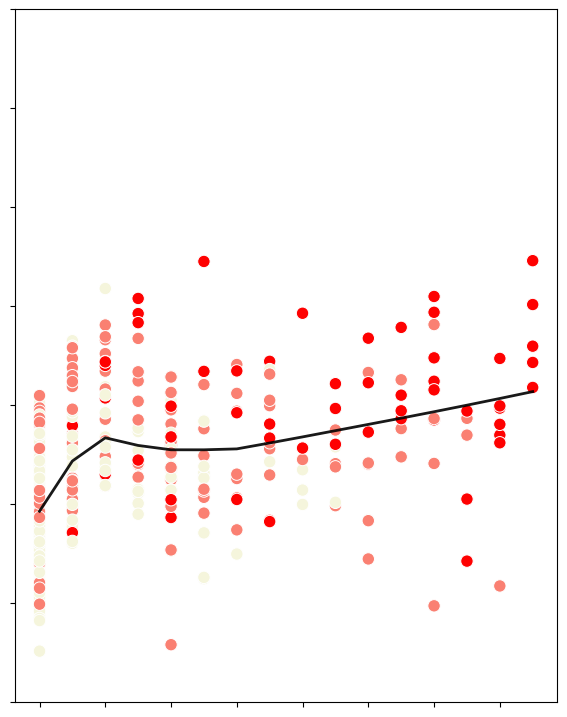

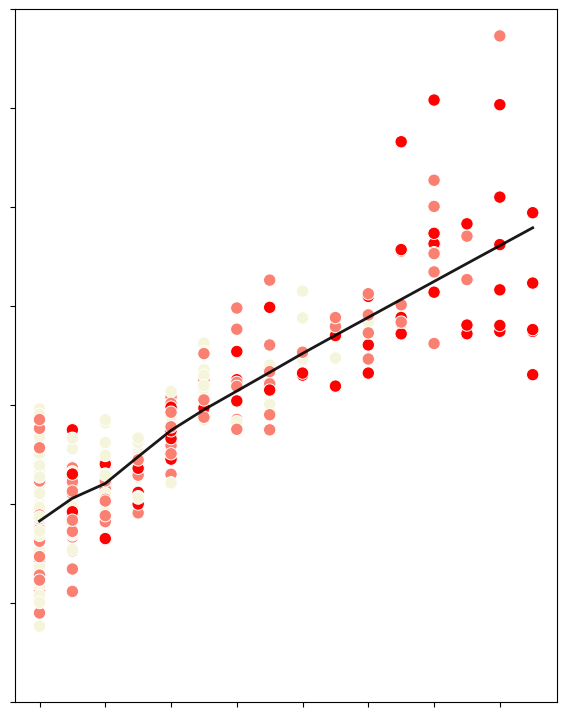

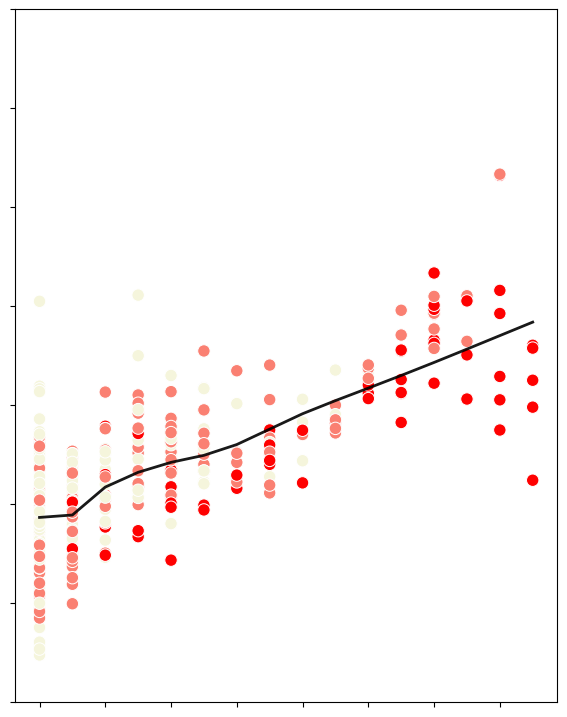

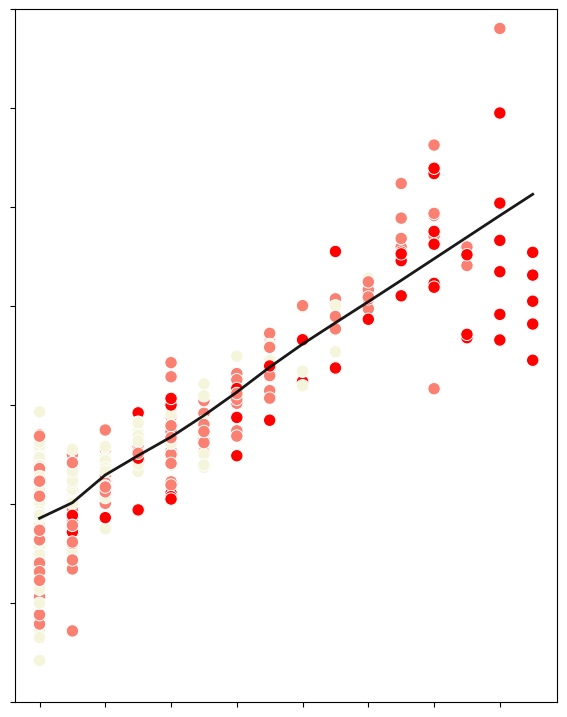

In [471]:
# Plot biomarker trajectories by diagnosis

for biomarker in biomarkers:
    fig, ax = plt.subplots(figsize=(7, 9))
    #plt.figure(figsize=(7, 9))  # Adjust figure size if needed

    # Plot scatter points
    sns.scatterplot(x='ml_stage', y=biomarker, data=zdata, 
                    hue='Diagnosis', palette=color_palette,
                    s=80, legend=False)  # Adjust scatter point size if needed

    # Add a regression line for all data
    sns.regplot(x='ml_stage', y=biomarker, data=zdata, 
                scatter=False, 
                color='black',  # Choose a color for the regression line
                lowess=True,
                line_kws={'lw': 2, 'alpha': 0.9})  # Thinner line (lw: line width)

    ax.set_ylim(-4, 10)

    # Add a title to the plot
    #plt.gcf().suptitle(str(biomarker) + ' vs. Stage', fontsize=14) 

    # Remove x and y axis labels
    ax = plt.gca()
    ax.set_xticklabels([])  # Hide x-axis tick labels but keep the tick marks
    ax.set_yticklabels([])  # Hide y-axis tick labels but keep the tick marks
    ax.set_xlabel('')  # Removing x-axis label if there is one
    ax.set_ylabel('')  # Removing y-axis label if there is one

    plt.show()

# Calculate y_k at each stage for a biomarker
Can use this code for any biomarker, including tau regional values and functional metrics. 

In [412]:
# Load data for biomarker of interest (in this case tau densities)
tau_data = pandas.read_csv('../data/ADNI3/Cog_Tau_V1.csv')

#Housekeeping
tau_data = tau_data.drop(['Unnamed: 0'], axis=1)
tau_data = tau_data.rename(columns ={'merge_RID' : 'RID'})

# Delete RIDs with NaN values in any column (only run for 'Cog_Tau_V1.csv') and redundant RIDS if cross-sectional 
#indices_to_drop = [97,105, 238, 250, 388, 400, 439, 454, 734, 778] 
#tau_data = tau_data.drop(indices_to_drop, axis=0)
value_to_drop = [4513, 6038, 6505, 6598, 6601, 6509]    
tau_data = tau_data[~tau_data['RID'].isin(value_to_drop)]
tau_data = tau_data.drop_duplicates(subset='RID', keep='first')

# Delete subjects with stages to exclude or diagnoses to exclude
tau_data = tau_data[tau_data['RID'].isin(reduced_RIDs)]

# Find the average of the right and left cerebellum 
tau_data['Average_Cerebellum'] = (tau_data['Left-Cerebellum-Cortex']+ tau_data['Right-Cerebellum-Cortex'])/2

# Divide each regional tau value by the average of R and L cerebellum tau and subtract 1
tau_data.iloc[:, 6:] = tau_data.iloc[:, 6:].div(tau_data['Average_Cerebellum'], axis=0) - 1

tau_data = tau_data.drop(columns=['Average_Cerebellum', 'MMSE_bl', 'ADAS11_bl', 'ADAS13_bl', 'merge_DX', 'best_DX'])

# Reset index for tau
tau_data.reset_index(drop=True, inplace=True)

In [413]:
# Check the same RIDs exist in tau data and zdata

rid_tau = set(tau_data['RID'])
rid_z = set(zdata['RID'])

# Find RIDs in df1 but not in df2
only_in_tau = rid_tau - rid_z

# Find RIDs in df2 but not in df1
only_in_z = rid_z - rid_tau

# Find RIDs common to both DataFrames
common_rids = rid_tau.intersection(rid_z)

# Print results
print("RIDs only in tau_data:", only_in_tau)
print("RIDs only in zdata:", only_in_z)
print("RIDs common to both DataFrames:", common_rids)


RIDs only in tau_data: set()
RIDs only in zdata: set()
RIDs common to both DataFrames: {6144, 6145, 6146, 6147, 4100, 6148, 6151, 4105, 6157, 6158, 6159, 6161, 4114, 4115, 2068, 21, 6163, 4119, 6164, 6168, 6173, 31, 6175, 6178, 6179, 6180, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 4148, 4149, 6197, 6199, 56, 6200, 6202, 59, 6203, 6204, 6206, 6207, 4160, 6209, 4162, 6211, 4164, 69, 6212, 2119, 6213, 2121, 4169, 2123, 6216, 6221, 6222, 4175, 4176, 4177, 2130, 4179, 6224, 2133, 6226, 6227, 6228, 6229, 6231, 4187, 6232, 6233, 6234, 6236, 96, 6237, 6240, 6243, 4090, 4197, 4198, 4199, 4200, 6250, 2155, 6251, 6252, 6253, 6255, 112, 6256, 4210, 6257, 4212, 4213, 4214, 6258, 120, 6259, 6260, 6264, 6266, 6268, 6269, 127, 4224, 6271, 6274, 6275, 2180, 4229, 6277, 2183, 6278, 6279, 4234, 2187, 6281, 6282, 142, 6283, 6284, 6287, 6288, 6289, 6291, 6292, 6293, 6294, 2200, 6297, 6298, 156, 6300, 4254, 6303, 6304, 6306, 6307, 6308, 4262, 6310, 6313, 6314, 2219, 2220, 6315, 6316, 4271, 4272, 6317, 6318,

# Gaussian Interpolation 
Create and plot a continuous time series from discrete y_k values for biomarker of interest

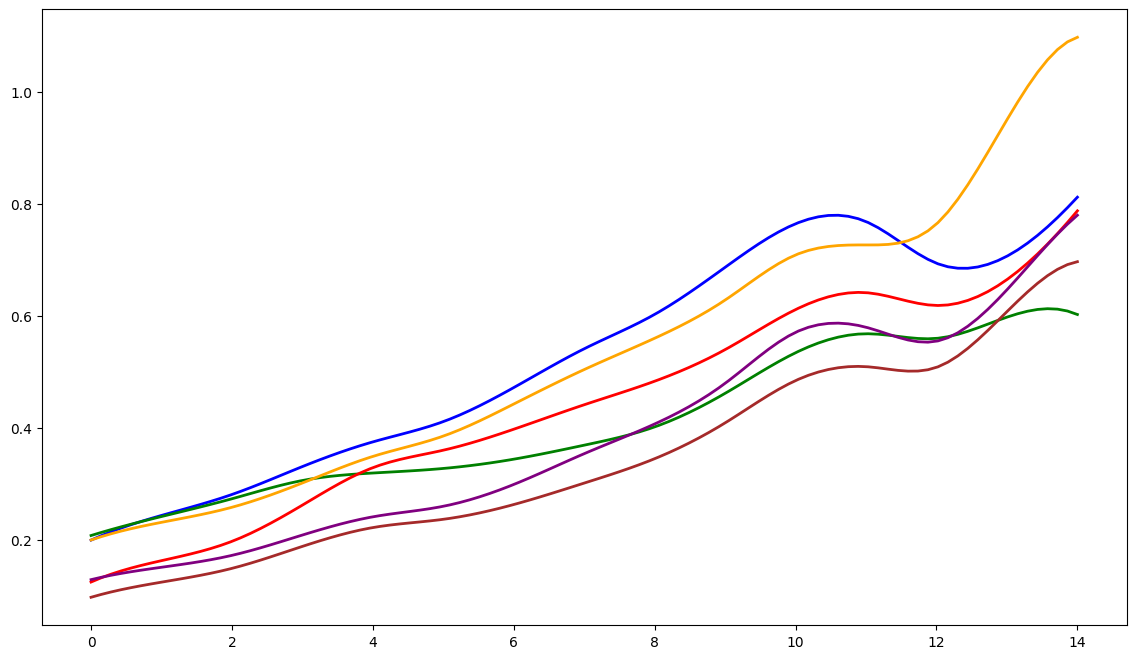

In [449]:
# Create a data frame for the stage probability distributions for each subject from pickle file
prob_stage = pandas.DataFrame(pk['prob_stage'])
ml_stage = pandas.DataFrame(pk['ml_stage'])
prob_stage = pandas.concat([ml_stage, prob_stage], axis=1)

# Delete subjects in stages to exclude
prob_stage = prob_stage[~prob_stage.iloc[:, 0].isin(stages_to_remove)]
prob_stage.drop(prob_stage.columns[0], axis=1, inplace=True)

# Define the number of stages 
stage_count = prob_stage.shape[1]

# Define biomarkers of interest
biomarkers_of_interest = [
    'Right-Amygdala', 'Right-Hippocampus', 'ctx-rh-entorhinal', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal', 'ctx-rh-parahippocampal']

# Set up the plot
plt.figure(figsize=(14, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']  # Define different colors for each biomarker

for biomarker, color in zip(biomarkers_of_interest, colors): 
    # Define biomarker data as an array dimensions 1 x i where i is the number of subjects
    biomarker_data = tau_data[biomarker]

    # Initialize lists of y(k) values and variance for each stage k
    biomarker_values = []
    variance_values = []

    for k in range(int(stage_count)):  # For each stage k
        total = 0  # Define a variable for the sum of all subjects i (numerator)

        for i in range(len(biomarker_data)):  # For each subject i 
            prob = prob_stage.iloc[i, k]  # Define the probability that subject i is in stage k 
            value = biomarker_data.iloc[i]  # Define the value of the biomarker for subject i 
            product = prob * value  # Multiply 
            total = total + product  # Add the product of the biomarker value and stage probability to the sum of i for stage k

        column_sum = np.sum(prob_stage.iloc[:, k])  # (denominator) 
        mean = total / column_sum  # Normalize with the sum of probabilities for each subject in stage k
        biomarker_values.append(mean)  # Save mean to biomarker_values list

        variance = 0  # Define variance for stage k
        
        for i in range(len(biomarker_data)):  # For each subject i 
            prob = prob_stage.iloc[i, k] 
            value = biomarker_data.iloc[i] 
            variance_individual = prob * (value - mean) ** 2
            variance = variance + variance_individual 

        variance = variance / len(biomarker_data)  # Normalize
        variance = math.sqrt(variance)  # Take the square root
        
        variance_values.append(variance)  # Save variance to list for stage k

    x = np.linspace(0, stage_count - 1, stage_count) 
    y = biomarker_values 
    variance = variance_values

    # Perform interpolation 
    f = interp1d(x, y, kind='cubic')

    # New x values for which we want to interpolate
    xnew = np.linspace(0, stage_count - 1, 100) 

    # Interpolate y values for the new x values
    ynew = f(xnew)

    # Create a shaded area for the error
    #upper = y + np.sqrt(variance)
    #lower = y - np.sqrt(variance)

    # Plotting
    #plt.fill_between(x, lower, upper, color=color, alpha=0.2)
    plt.plot(xnew, ynew, '-', color=color, label=biomarker, linewidth=2)

# Add legend, labels, and title
#plt.legend()
#plt.xlabel('Stages')
#plt.ylabel('Tau density')
#plt.title('Regional Tau Gaussian Interpolations')
#plt.ylim(bottom=0, top=5)
    
# Remove x and y axis labels
# ax = plt.gca()
# ax.set_xticklabels([])  # Hide x-axis tick labels but keep the tick marks
# ax.set_yticklabels([])  # Hide y-axis tick labels but keep the tick marks
# ax.set_xlabel('')  # Removing x-axis label if there is one
# ax.set_ylabel('')  # Removing y-axis label if there is one


In [415]:
# Alternate probability heatmap for cognitive score order with overlay 

# Add diagnosis, cognitive score, and ml_stage to data frame
prob_stage_plot = pandas.merge(zdata,prob_stage,left_index=True, right_index=True)
prob_stage_plot = prob_stage_plot.iloc[:,[1, 3, 22] + list(range(24, prob_stage_plot.shape[1]))]

# Define your custom colormap
colors = [
    "#f4cca1",  # beige
    "#ff8c69",  # light salmon (intermediate color for smoother transition)
    "#ff5533",  # tomato red (stronger red)
    "#ff2200",  # orange red (more intense)
    "#760909"   # red (most intense)
]
custom_red_colormap = LinearSegmentedColormap.from_list("custom_red", colors)

# By cognitive score
by_cog = prob_stage_plot.sort_values(by='ADAS11_bl')
# Normalize ADAS11_bl scores to the range of indices used in the x-axis of the heatmap
normalized_ADAS11 = (by_cog['ADAS11_bl'] - by_cog['ADAS11_bl'].min()) / (by_cog['ADAS11_bl'].max() - by_cog['ADAS11_bl'].min())
scaled_ADAS11_x = normalized_ADAS11 * (by_cog.shape[1] - 3.5)  # Scale to width of heatmap
by_cog = by_cog.iloc[:,3:]
plt.figure(figsize=(8,10))
plt.imshow(by_cog, cmap=custom_red_colormap, interpolation='none', aspect='auto')
# Generate y-values for the line plot (assuming a simple sequential order, you may adjust as needed)
y_values = np.arange(by_cog.shape[0])
# Overlay the line representing the ADAS11 score for each subject
plt.plot(scaled_ADAS11_x, y_values, color='black', marker='o', linestyle='-', linewidth=2, markersize=1, label='ADAS11 Score Line')
ax = plt.gca()  # Get the current axes
ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks

# Create a secondary x-axis
ax2 = plt.twiny()
# Define new x-ticks for the secondary x-axis. Ensure they align with primary axis
new_tick_positions = [-2, 1, 4, 7, 10, 13]  # Specify positions where you want ticks

# Set the ticks and labels for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())  # Ensure alignment with primary x-axis
ax2.set_xticks(new_tick_positions)  # Set the ticks at desired positions

# Provide labels for these tick positions
#ax2.set_xticklabels(['-2', '0', '2', '4', '6', '8'])  # Corresponding labels for each tick
ax2.set_xticklabels([])

# Add a label to the secondary x-axis
#ax2.set_xlabel('ADAS11')

# Customize the plot
#plt.xlabel('Stage')
plt.ylabel('Subjects')
#plt.title('Heatmap with ADAS11 Score Overlay')
#plt.legend()
plt.show()

KeyError: 'ADAS11_bl'

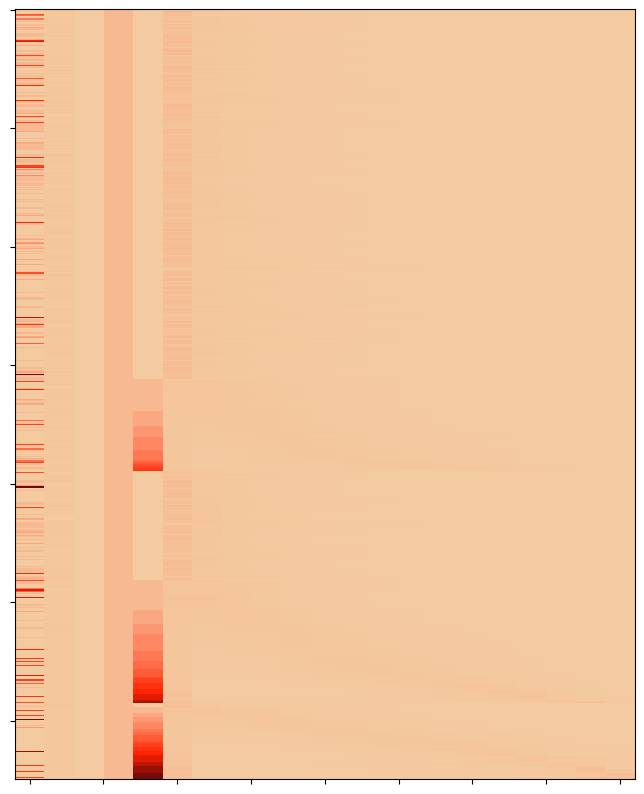

KeyError: 'ADAS11_bl'

In [417]:
# Plot probability stage matrix

# Add diagnosis, cognitive score, and ml_stage to data frame
prob_stage_plot = pandas.merge(zdata,prob_stage,left_index=True, right_index=True)
prob_stage_plot = prob_stage_plot.iloc[:,[1, 3, 22] + list(range(24, prob_stage_plot.shape[1]))]

# Define your custom colormap
colors = [
    "#f4cca1",  # beige
    "#ff8c69",  # light salmon (intermediate color for smoother transition)
    "#ff5533",  # tomato red (stronger red)
    "#ff2200",  # orange red (more intense)
    "#760909"   # red (most intense)
]
custom_red_colormap = LinearSegmentedColormap.from_list("custom_red", colors)

# Plotting by diagnosis
CN = prob_stage_plot[prob_stage_plot['Diagnosis'] == 'CN']
MCI = prob_stage_plot[prob_stage_plot['Diagnosis'] == 'MCI']
AD = prob_stage_plot[prob_stage_plot['Diagnosis'] == 'Dementia']
CN_by_stage = CN.sort_values(by='ml_stage')
MCI_by_stage = MCI.sort_values(by='ml_stage')
AD_by_stage = AD.sort_values(by='ml_stage')
by_diagnosis = pandas.concat([CN_by_stage, MCI_by_stage, AD_by_stage], ignore_index=True)
by_diagnosis = by_diagnosis.iloc[:,3:]
plt.figure(figsize=(8, 10))
plt.imshow(by_diagnosis, cmap=custom_red_colormap, interpolation='none', aspect='auto')
ax = plt.gca()  # Get the current axes
ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks
plt.show()

# By cognitive score
by_cog = prob_stage_plot.sort_values(by='ADAS11_bl')
by_cog = by_cog.iloc[:,3:]
plt.figure(figsize=(8, 10))
plt.imshow(by_cog, cmap=custom_red_colormap, interpolation='none', aspect='auto')
#ax = plt.gca()  # Get the current axes
#ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
#ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks


# By most likely stage 
by_stage = prob_stage_plot.sort_values(by='ml_stage')
by_stage = by_stage.iloc[:,3:]
plt.figure(figsize=(8, 10))
plt.imshow(by_stage, cmap=custom_red_colormap, interpolation='none', aspect='auto')
#ax = plt.gca()  # Get the current axes
#ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
#ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks



plt.show()

# Calculate a continous time series for a biomarker in every brain region
Perform the above operations for every brain region (currently looking at tau)

In [418]:
# Now let's calculate an interpolation for tau in every region 

column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

if nsubtypes > 1:

    tau_array_dicts = {}
    tau_df_dicts = {}

    for subtype in range(1,nsubtypes + 1):

        tau_array_dicts[subtype] = None
         
        for region in tau_array_dicts[subtype].columns[6:]: # Loop through tau in every region 

            # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
            biomarker_of_interest = region  
            
            # Extract the biomarker data for the current subtype
            biomarker_data = tau_array_dicts[subtype][biomarker_of_interest]

            #Initialize list of y(k) values for each stage k within biomarkers_values dictionary 
            biomarker_values_dicts[subtype] = []

            for k in range(int(stage_count)): # For each stage k
                sum = 0 # Define a variable for sum of all subjects i (numerator)

                for i in range(len(biomarker_data)): # For each subject i 
        
                    prob = prob_stage_dicts[subtype].iloc[i, k] # Define the probability that subject i is in stage k
                    value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                    product = prob * value # Multiply 
                    sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

                column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

                final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
                biomarker_values_dicts[subtype].append(final_value) # Save sum to biomarker_values list

            x = np.linspace(0, stage_count - 1,stage_count) 
            y = biomarker_values_dicts[subtype]

            # Perform interpolation 
            f = interp1d(x, y, kind='cubic')

            # New x values for which we want to interpolate
            xnew = np.linspace(0,stage_count - 1,100) 

            # Interpolate y values for the new x values
            ynew = f(xnew)

            if tau_array_dicts[subtype] is None:
                tau_array_dicts[subtype] = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
            else:
                tau_array_dicts[subtype] = np.vstack((tau_array_dicts[subtype], ynew))
        
        print('Subtype ' + str(subtype) + ' regional tau: ' + str(tau_array_dicts[subtype]))

        # Convert tau array to labeled data frame and save to csv
        transpose_array = tau_array_dicts[subtype].T

        tau_df_dicts[subtype] = pandas.DataFrame(data=transpose_array, columns = column_labels)

else: 

    # Define an array for tau interpolations in every brain region
    tau_array = None
    
    for region in tau_data.columns[1:]: # Loop through tau in every region 
    
        # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
        biomarker_of_interest = region  
        biomarker_data = tau_data[biomarker_of_interest] 

        # Initialize list of y(k) values for each stage k
        biomarker_values = []
    
        for k in range(int(stage_count)): # For each stage k
            sum = 0 # Define a variable for sum of all subjects i (numerator)
    
            for i in range(len(zdata)): # For each subject i 
        
                prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k 
                value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                product = prob * value # Multiply 
                sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

            column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

            final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
            biomarker_values.append(final_value) # Save sum to biomarker_values list

    
        # Perform Gaussian interpolation with scipy.interpolate.interp1d

        x = np.linspace(0, stage_count - 1,stage_count) 
        y = biomarker_values

        # Perform interpolation 
        f = interp1d(x, y, kind='cubic')

        # New x values for which we want to interpolate
        xnew = np.linspace(0,stage_count - 1,100) 

        # Interpolate y values for the new x values
        ynew = f(xnew)

        if tau_array is None:
            tau_array = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
        else:
            tau_array = np.vstack((tau_array, ynew))
        
    print('Regional tau: ' + str(tau_array))

    # Convert tau array to labeled data frame 
    transpose_array = tau_array.T

    column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

    tau_df = pandas.DataFrame(data=transpose_array, columns = column_labels)
        

Regional tau: [[0.19131165 0.19587391 0.20012432 ... 0.93859859 0.95777384 0.97269964]
 [0.0288029  0.03004235 0.0313523  ... 0.36503146 0.37540008 0.38475677]
 [0.03035308 0.0343301  0.0379993  ... 0.50773996 0.50877665 0.50537618]
 ...
 [0.20004934 0.20779331 0.21489769 ... 0.77545097 0.79314044 0.8118624 ]
 [0.23061732 0.23580645 0.24075647 ... 0.5621589  0.57077215 0.57719459]
 [0.24346125 0.24558044 0.24776164 ... 0.31110321 0.30963901 0.30728015]]


In [419]:
# Exclude striatal regions

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Delete striatal regions in tau_df
tau_df_excluded = tau_df.drop(columns=regions_to_exclude)
tau_array_excluded = tau_df_excluded.to_numpy()
tau_array_excluded = tau_array_excluded.T


In [421]:
# Save data frame to csv

if nsubtypes > 1:

    for subtype in range(1,nsubtypes + 1):
    
        tau_df_dicts[subtype].to_csv(f'EBM output - subtyping.csv') # EDIT CSV NAME HERE


else:
    tau_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM time series/EBM time series - version 9 final run.csv') # EDIT CSV NAME HERE



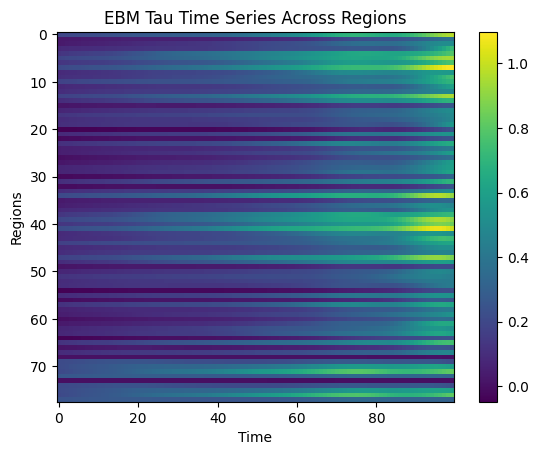

In [420]:
# Generate heatmap

if nsubtypes > 1:

    for subtype in range(1,nsubtypes + 1):

        plt.imshow(tau_array_dicts[subtype], cmap='viridis', interpolation='none')
        plt.colorbar()  # Add a color bar to map colors to values
        plt.title('Heatmap of Tau Time Series- Subtype ' + str(subtype))
        plt.show()

else:
    plt.imshow(tau_array_excluded, cmap='viridis', interpolation='none', aspect='auto')
    plt.colorbar()  # Add a color bar to map colors to values
    plt.title('EBM Tau Time Series Across Regions')
    plt.xlabel('Time')  # Replace with your actual label
    plt.ylabel('Regions')
    plt.show()

In [422]:
# Preparing data frame for Nexis on individual subjects

stage_data = zdata[['RID', 'Diagnosis', 'ml_stage']]

final = pandas.merge(stage_data, tau_data, on='RID', how='inner')

final.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM stage + tau/Stage + tau - version 9 final run.csv')